# Streaming Anomaly and Outlier Detection Methods

In [54]:
import collections
import functools
from pysad.evaluation import AUROCMetric
from pysad.models import xStream, ExactStorm, HalfSpaceTrees, IForestASD, KitNet, KNNCAD, LODA, LocalOutlierProbability, \
    MedianAbsoluteDeviation, RelativeEntropy, RSHash, RobustRandomCutForest, StandardAbsoluteDeviation
from pysad.transform.preprocessing import InstanceUnitNormScaler, InstanceStandardScaler
from pysad.transform.probability_calibration import ConformalProbabilityCalibrator
from river import compose
from river import datasets
from river import metrics
from river import preprocessing
from river import anomaly
import dill as pickle

import numpy as np

import matplotlib.pyplot as plt


## Dataset
Run the preprocessing notebook to generate the dataset

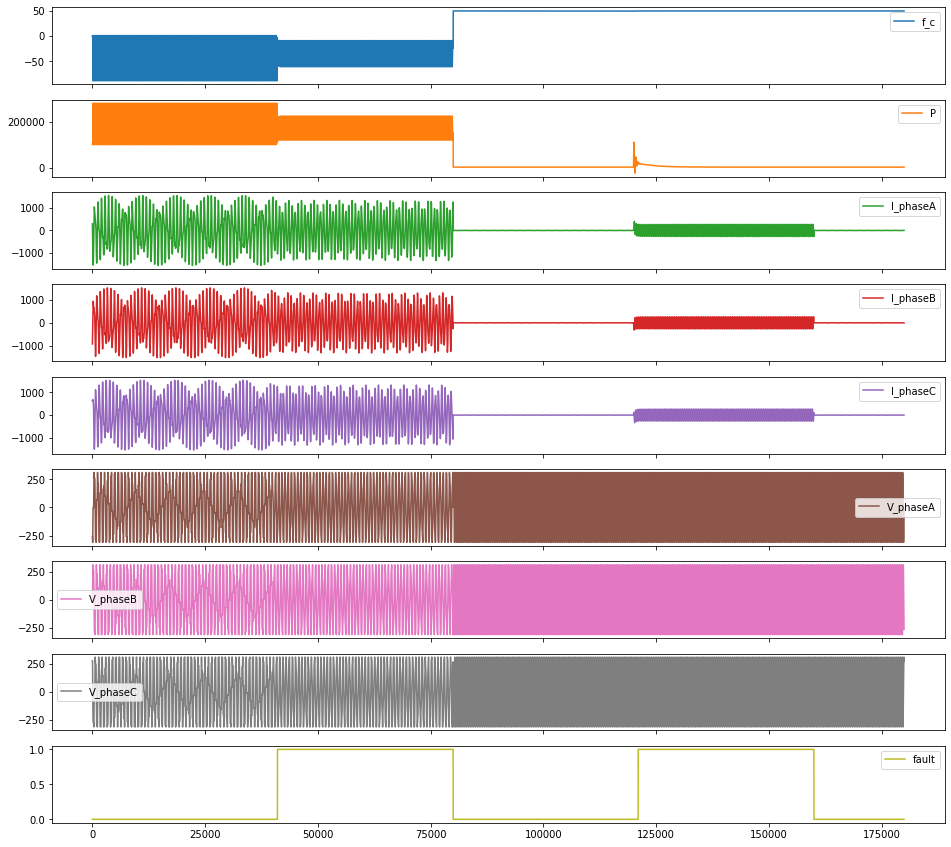

In [31]:
keys = ["f_c","P","I_phaseA","I_phaseB","I_phaseC","V_phaseA","V_phaseB","V_phaseC","fault"]
with open('../#datasets/Weak_Grid-7_5_mH.pkl', 'rb') as file:
    df= pickle.load(file)
df = df[:180000].copy()
df[keys].plot(subplots=True, figsize=(16,15));


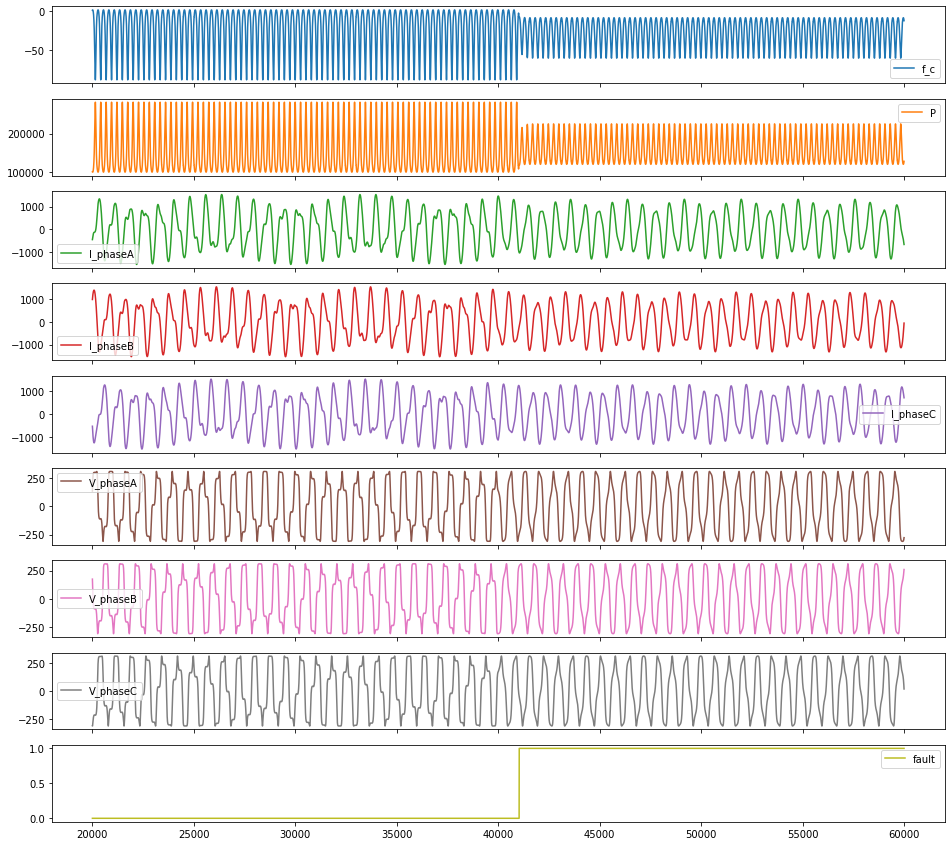

In [32]:
river_df = df[20000:60000].copy()
river_df[keys].plot(subplots=True, figsize=(16,15));

## River

index: 20000
index: 30000
index: 40000
index: 50000
AUC: ROCAUC: 0.476982


Text(0.5, 1.0, 'Detection Method: River HST')

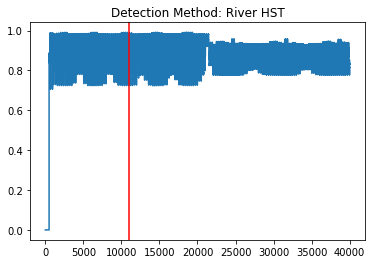

In [33]:
model_keys = ["f_c","P"]
model = compose.Pipeline(
     preprocessing.RobustScaler(with_centering=True, with_scaling=True ),
     # preprocessing.MinMaxScaler(),
     anomaly.HalfSpaceTrees(seed=42,
        n_trees=10,
        height=8,
        window_size=500)
 )
auc = metrics.ROCAUC()

score_list = []
count = 0
prob = ConformalProbabilityCalibrator(windowed=True, window_size=300)
for index, row in river_df.iterrows():
    # features = row.iloc[0:12]
    features = row[model_keys]
    y = row["fault"]
    model = model.learn_one(features)
    score = model.score_one(features)
    anomaly_score = score
    prob_score = anomaly_score
    # if not isinstance(anomaly_score, list):
    #     anomaly_score = np.reshape(score, (-1,1))
    # prob_score = prob.fit_transform(anomaly_score)
    score_list.append(prob_score)
    auc = auc.update(y, prob_score)
    if prob_score > 0.9:
        count += 1
    if index % 10000 == 0:
        print(f"index: {index}")
#     print(f'Anomaly score for x={x:.3f}: {score:.3f}')
print(f'AUC: {auc}')
plt.figure()
plt.plot(score_list)
plt.axvline(x=41030-30000,color='r')
plt.title("Detection Method: River HST")

## PySad

In [89]:
from sklearn import preprocessing as preproc

model_classes = {
        # ExactStorm.__name__: { "model": ExactStorm(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                 "metric": AUROCMetric()},
        # IForestASD.__name__: { "model": xStream(),
        #                                    "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                    "count": 0,
        #                                    "scores": [],
        #                                    "metric": AUROCMetric()},
        # KitNet.__name__: { "model":KitNet(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                "metric": AUROCMetric()},
        # LODA.__name__: { "model":LODA(),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "count": 0,
        #                        "scores": [],
        #                         "metric": AUROCMetric()},
        # MedianAbsoluteDeviation.__name__: { "model":MedianAbsoluteDeviation(),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "count": 0,
        #                        "scores": [],
        #                         "metric": AUROCMetric()},
        # RelativeEntropy.__name__: { "model":RelativeEntropy(0.0, 1.0),
        #                        "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                        "count": 0,
        #                        "scores": [],
        #                         "metric": AUROCMetric()},
        RSHash.__name__: { "model":RSHash(feature_mins=[[-1000.0,-1000.0,-1000.0, -250.0,-250.0,-250.0]], feature_maxes=[[1000.0,1000.0,1000.0,250.0,250.0,250.0]]),
                               "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                               "count": 0,
                               "scores": [],
                                "metric": AUROCMetric()},
        # StandardAbsoluteDeviation.__name__: { "model":StandardAbsoluteDeviation(),
        #                            "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                            "count": 0,
        #                            "scores": [],
        #                             "metric": AUROCMetric()},
        # xStream.__name__: {"model": xStream(),
        #                                "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                                "count": 0,
        #                                "scores": [],
        #                                 "metric": AUROCMetric()},
        RobustRandomCutForest.__name__: {"model": RobustRandomCutForest(),
                                   "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
                                   "count": 0,
                                   "scores": [],
                                    "metric": AUROCMetric()},
        # HalfSpaceTrees.__name__: { "model": HalfSpaceTrees([0.0],[1.0]),
        #                            "calibrator": ConformalProbabilityCalibrator(windowed=True, window_size=300),
        #                            "count": 0,
        #                            "scores": [],
        #                             "metric": AUROCMetric()},
    }

# model_keys = ["f_c","P","I_phaseA","I_phaseB","I_phaseC","V_phaseA","V_phaseB","V_phaseC"]
model_keys = ["I_phaseA","I_phaseB","I_phaseC","V_phaseA","V_phaseB","V_phaseC"]
print(model_classes.keys())
# print(df.loc[df['fault'] == 1])
fault_index = 41030
# interval = 200
interval = 5000

pysad_df = df[fault_index-interval:fault_index+interval].copy()
for key, props in model_classes.items():
    print(f"Starting running: {key}")

    preprocessor = InstanceStandardScaler()  # Init normalizer.
    scaler = preprocessing.RobustScaler()
    for index, row in pysad_df.iterrows():
        x = row[model_keys].values
        # x = preprocessor.fit_transform_partial(x)# Fit preprocessor to and transform the instance.
        # print(x)
        # x = scaler.learn_one(x).transform_one(x)
        # print(x)
        x = np.reshape(x, (-1,1))
        y = bool(row["fault"])
        anomaly_score = props["model"].fit_score_partial(x,y) # Fit to an instance x and score it.
        # if anomaly_score:
        #     if not isinstance(anomaly_score, list):
        #         anomaly_score = np.reshape(anomaly_score, (-1,1))
        #     anomaly_score = props["calibrator"].fit_transform(anomaly_score)
        # print(anomaly_score)
        # print(y)
        props["metric"].update(y, anomaly_score)

        props["scores"].append(anomaly_score)
        # Output if the instance is anomalous.
        if anomaly_score > 0.90:
            props["count"] += 1# If probability of being normal is less than 5%.
            # print(f"Alert: {i}th data point is anomalous.")
        if index % 100 == 0:
            print(f"index: {index}")

    print(f"Finished running: {key}")
print("Done")


dict_keys(['RSHash', 'RobustRandomCutForest'])
Starting running: RSHash
index: 36100
index: 36200
index: 36300
index: 36400
index: 36500
index: 36600
index: 36700
index: 36800
index: 36900
index: 37000
index: 37100
index: 37200
index: 37300
index: 37400
index: 37500
index: 37600
index: 37700
index: 37800
index: 37900
index: 38000
index: 38100
index: 38200
index: 38300
index: 38400
index: 38500
index: 38600
index: 38700
index: 38800
index: 38900
index: 39000
index: 39100
index: 39200
index: 39300
index: 39400
index: 39500
index: 39600
index: 39700
index: 39800
index: 39900
index: 40000
index: 40100
index: 40200
index: 40300
index: 40400
index: 40500
index: 40600
index: 40700
index: 40800
index: 40900
index: 41000
index: 41100
index: 41200
index: 41300
index: 41400
index: 41500
index: 41600
index: 41700
index: 41800
index: 41900
index: 42000
index: 42100
index: 42200
index: 42300
index: 42400
index: 42500
index: 42600
index: 42700
index: 42800
index: 42900
index: 43000
index: 43100
index

C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
C:\ProgramData\Anaconda3\envs\FIREMAN-project\lib\site-packages\sklearn\utils\validation.py:673: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuple

RSHash - ROC: 0.60515372 & Detected Anomalies 923
RobustRandomCutForest - ROC: 0.51127044 & Detected Anomalies 950
River - HST ROCAUC: 0.476982


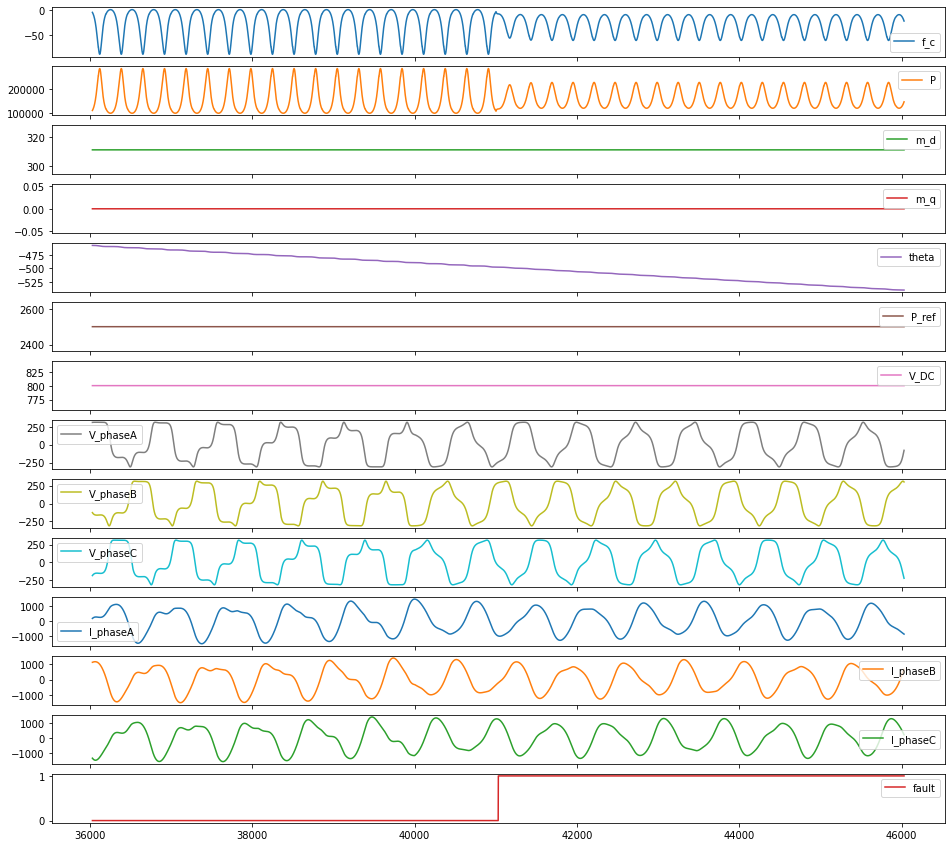

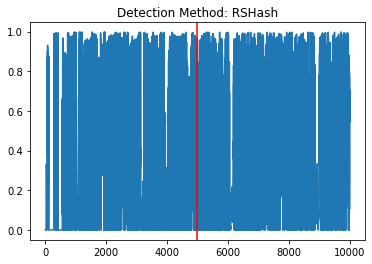

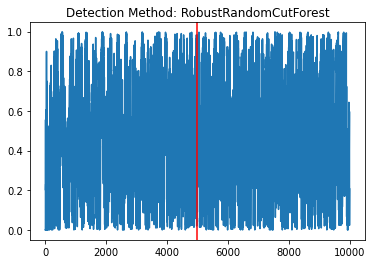

In [90]:
pysad_df.plot(subplots=True, figsize=(16,15))
for key, props in model_classes.items():
    print(f'{key} - ROC: {props["metric"].get()} & Detected Anomalies {props["count"]}')
print(f'River - HST {auc}')
for key, props in model_classes.items():
    plt.figure()
    plt.plot(props["scores"],label=key)
    plt.title(f"Detection Method: {key}")
    plt.axvline(x=interval,color='r')

# plt.figure()
# plt.plot(score_list)
# plt.title("Detection Method: River HST")